## Model evaluation using cross-validation

In this notebook, we still use numerical features only.

Here we discuss the practical aspects of assessing the generalization performance of our model via cross-validation instead of a single train-test split.

### Data preparation

First, let's load the full adult census dataset.


In [1]:
import pandas as pd

adult_census = pd.read_csv("/content/drive/MyDrive/DataSets/Adult_Census/adult-census(1).csv")

In [2]:
# We now drop the target from the data we will use to train our predictive model.
target_name = "class"
target = adult_census[target_name]
data = adult_census.drop(columns=target_name)

In [3]:
# Then, we select only the numerical columns, as seen in the previous notebook.
numerical_columns = ["age", "capital-gain", "capital-loss", "hours-per-week"]

data_numeric = data[numerical_columns]

We can now create a model using the make_pipeline tool to chain the preprocessing and the estimator in every iteration of the cross-validation

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())

## The need for cross-validation

In the previous notebook, we split the original data into a training set and a testing set. The score of a model in general depends on the way we make such a split. One downside of doing a single split is that it does not give any information about this variability. Another downside, in a setting where the amount of data is small, is that the data available for training and testing would be even smaller after splitting.

Instead, we can use cross-validation. Cross-validation consists of repeating the procedure such that the training and testing sets are different each time. Generalization performance metrics are collected for each repetition and then aggregated. As a result we can assess the variability of our measure of the model's generalization performance.

Note that there exists several cross-validation strategies, each of them defines how to repeat the fit/score procedure. In this section, we use the K-fold strategy: the entire dataset is split into K partitions. The fit/score procedure is repeated K times where at each iteration K - 1 partitions are used to fit the model and 1 partition is used to score. The figure below illustrates this K-fold strategy.
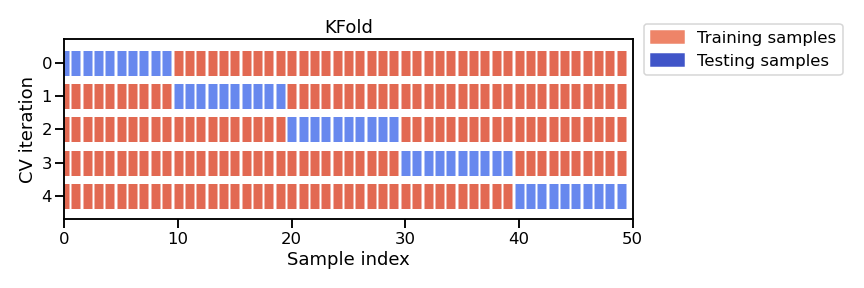



Note

This figure shows the particular case of K-fold cross-validation strategy. For each cross-validation split, the procedure trains a clone of model on all the red samples and evaluate the score of the model on the blue samples. As mentioned earlier, there is a variety of different cross-validation strategies. Some of these aspects will be covered in more detail in future notebooks.

Cross-validation is therefore computationally intensive because it requires training several models instead of one.

In scikit-learn, the function cross_validate allows to do cross-validation and you need to pass it the model, the data, and the target. Since there exists several cross-validation strategies, cross_validate takes a parameter cv which defines the splitting strategy.

In [5]:
%%time
from sklearn.model_selection import cross_validate

model = make_pipeline(StandardScaler(), LogisticRegression())
cv_result = cross_validate(model, data_numeric, target, cv=5)
cv_result

CPU times: user 1.22 s, sys: 427 ms, total: 1.65 s
Wall time: 2.06 s


{'fit_time': array([0.32372379, 0.23668385, 0.27143431, 0.27606344, 0.3240478 ]),
 'score_time': array([0.10169291, 0.03936744, 0.06630135, 0.0941453 , 0.06552982]),
 'test_score': array([0.79557785, 0.80049135, 0.79965192, 0.79873055, 0.80436118])}

The output of cross_validate is a Python dictionary, which by default contains three entries:

    (i) the time to train the model on the training data for each fold, fit_time
    (ii) the time to predict with the model on the testing data for each fold, score_time
    (iii) the default score on the testing data for each fold, test_score.

Setting cv=5 created 5 distinct splits to get 5 variations for the training and testing sets. Each training set is used to fit one model which is then scored on the matching test set. The default strategy when setting cv=int is the K-fold cross-validation where K corresponds to the (integer) number of splits. Setting cv=5 or cv=10 is a common practice, as it is a good trade-off between computation time and stability of the estimated variability.

Note that by default the cross_validate function discards the K models that were trained on the different overlapping subset of the dataset. The goal of cross-validation is not to train a model, but rather to estimate approximately the generalization performance of a model that would have been trained to the full training set, along with an estimate of the variability (uncertainty on the generalization accuracy).

You can pass additional parameters to sklearn.model_selection.cross_validate to collect additional information, such as the training scores of the models obtained on each round or even return the models themselves instead of discarding them. These features will be covered in a future notebook.

Let's extract the scores computed on the test fold of each cross-validation round from the cv_result dictionary and compute the mean accuracy and the variation of the accuracy across folds.


In [6]:
scores = cv_result["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.800 ± 0.003


Note that by computing the standard-deviation of the cross-validation scores, we can estimate the uncertainty of our model generalization performance. This is the main advantage of cross-validation and can be crucial in practice, for example when comparing different models to figure out whether one is better than the other or whether our measures of the generalization performance of each model are within the error bars of one-another.

In this particular case, only the first 2 decimals seem to be trustworthy. If you go up in this notebook, you can check that the performance we get with cross-validation is compatible with the one from a single train-test split.
